# The Annotated Transformer Tutorial
This is a reimplementation of the famous [Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) that I did to better understand the transformer.

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math, time, pdb
import numpy as np
np.set_printoptions(precision=4)

from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="talk")
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import pytorch_lightning as pl

## Functions

In [3]:
clones = lambda module, n: nn.ModuleList([deepcopy(module) for _ in range(n)])

def subsequent_mask(size):
  """
  Function to mask subsequent positions in the output.
  This is done to prevent the decoder stack from attending to
  subsequent positions and ensures that the predictions for any
  position can depend only on the known outputs at the positions before.
  """
  attn_shape = (1, size, size)
  subsq_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  return torch.from_numpy(subsq_mask) == 0

## Connection Layers

In [4]:
class LayerNorm(nn.Module):
  """
  Construct a layernorm module.
  TODO: Replace this with Pytorch's inbuilt LayerNorm class
  """
  def __init__(self, features, eps=1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps
    
  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class ResidualConnection(nn.Module):
  """
  A residual connection followed by a layer norm.
  Note for code simplicity the norm is first as opposed to last.
  """
  def __init__(self, size, dropout):
    super(ResidualConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)
    
  def forward(self, x, sublayer):
    """
    Apply residual connection to any subplayer with the same size.
    """
    return x + self.dropout(subplayer(self.norm(x)))  

## Encoder

In [5]:
class EncoderStack(nn.Module):
  """
  Encoder stack is a stack of 'n' encoder layers.
  """
  def __init__(self, encoder, n_layers):
    super(EncoderStack, self).__init__()
    self.encoders = clones(encoder, n_layers)
    self.norm = LayerNorm(layer.size) # change this to pytorch's LayerNorm
    
  def forward(self, x, mask):
    """
    Pass the input (and mask) through each encoder in turn.
    """
    for encoder in self.encoders:
      x = encoder(x, mask)
      
    return self.norm(x)

class Encoder(nn.Module):
  """
  The encoder is made up of a self attention layer and a feed forward layer.
  """
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(Encoder, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.subplayer = clones(ResidualConnection(size, dropout), 2)
    self.size = size
    
  def forward(self, x, mask):
    """
    This function does the following:
    1. Three copies corresponding of the input to the query, key, and value along
       with the mask is fed into the self attention layer
    2. Output from 1 is sent to residual connection layer which also applies
       layer normalization
    3. Output from 2 is fed into the feed forward layer
    4. Output from 3 is sent to residual connection layer which also applies
       layer normalization
    """
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

## Decoder

In [6]:
class DecoderStack(nn.Module):
  """
  Generic 'n' layer decoder stack with masking.
  """
  def __init__(self, decoder, n_layers):
    super(DecoderStack, self).__init__()
    self.decoders = clones(decoder, n_layers)
    self.norm = LayerNorm(layer.size) # change this to pytorch's LayerNorm
    
  def forward(self, x, encoder_output, src_mask, target_mask):
    for decoder in self.decoders:
      x = decoder(x, encoder_output, src_mask, target_mask)
      
    return self.norm(x) 

In [7]:
class Decoder(nn.Module):
  """
  The decoder is made up of self attention, source attention
  providing the keys and values from the encoder output, and feed forward.
  """
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(Decoder, self).__init__()
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.subplayer = clones(ResidualConnection(size, dropout), 3)
    self.size = size
    
  def forward(self, x, encoder_output, src_mask, target_mask):
    """
    This function does the following:
    1. Three copies corresponding of the generated output to the query, key, and value along
       with the mask is fed into the self attention layer
    2. Output from 1 is sent to residual connection layer which also applies
       layer normalization
    3. Output from 2 is fed into the source attention layer, with the keys and values
       coming from the encoder and query coming from step 2
    4. Output from 3 is sent to residual connection layer which also applies
       layer normalization
    5. Output from 4 is fed into a feed forward layer which is then sent to the
       residual connection layer
    """
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, target_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x, encoder_output, encoder_output, src_mask))
    return self.sublayer[2](x, self.feed_forward)

## Attention

In [8]:
def attention(query, key, value, mask=None, dropout=None):
  """
  Compute 'Scaled Dot Product Attention'
  """
  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # scale for stable gradients
  if mask is not None:
    scores = scores.maksed_fill(mask == 0, -1e9)
  p_attn = F.softmax(scores, dim=-1)
  if dropout is not None:
    p_attn = dropout(p_attn)
    
  return torch.matmul(p_attn, value), p_attn

In [9]:
class MultiHeadAttention(nn.Module):
  """
  Class impelementing multiple attention cells each with its 
  own query, key, and value vectors that are used to calculate 
  scores and output vectors which are concatenated and passed through
  a linear layer to get the final output.
  """
  def __init__(self, h, d_model, dropout=0.1):
    super(MultiHeadAttention, self).__init__()
    assert d_model % h == 0 # assume d_v = d_k
    self.d_k = d_model // h
    self.h = h
    self.linears = clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(dropout)

  def forward(self, query, key, value, mask=None):
    if mask is not None:
      mask = mask.unsqueeze(1) # same mask is applied to all h heads
    
    nbatchs = query.size(0)
    
    # 1) The query, key, and value vectors are first fed into the linear layers by
    #    all the linear projections in a batch from d_model => h x d_k
    query, key, value = [l(x).view(nbatchs, -1, self.h, self.d_k).transpose(1, 2) for l,x in zip(self.linears, (query, key, value))]
    
    # 2) Apply attention on all the projected vectors in a batch
    x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
    
    # 3) "concat" using view and apply a final linear
    x = x.transpose(1, 2).contiguous().view(nbatchs, -1, self.h * self.d_k)
    
    return self.linears[-1](x)    

## Feedforward, Embeddings, and Positional Encoding

In [10]:
class PositionWiseFeedForward(nn.Module):
  """
  Implements the feed forward part of the encoder
  """
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionWiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)
    
  def forward(self, x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [11]:
class Embeddings(nn.Module):
  """
  Input and output embedding layers.
  """
  def __init__(self, d_model, vocab):
    super(Embeddings, self).__init__()
    self.lut = nn.Embedding(vocab, d_model)
    self.d_model = d_model
    
  def forward(self, x):
    return self.lut(x) * math.sqrt(self.d_model)

In [12]:
class PositionalEncoding(nn.Module):
  """
  Positional encoding function
  Even position i pe(pos, 2i) = sin(pos/10000^(2i/d_model))
  Odd position i pe(pos, 2i+1) = cos(pos/10000^(2i/d_model))
  """
  def __init__(self, d_model, dropout, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(dropout)

    # Compute the positional encodings once in log space.
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    self.pe = pe.unsqueeze(0)

  def forward(self, x):
    x = x + self.pe[:, :x.size(1)]
    return self.dropout(x)

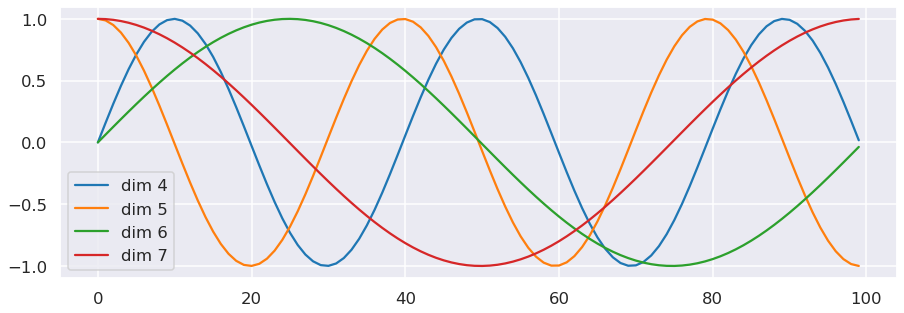

In [14]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
pe = PositionalEncoding(20, 0)
y = pe(torch.zeros(1, 100, 20))
ax.plot(np.arange(100), y[0, :, 4:8].data.numpy())
ax.legend(["dim %d"%p for p in [4,5,6,7]])

## Final Model Architecture

In [ ]:
class Transformer(nn.Module):
  """
  The main Transformer architecture made up of an encoder
  stack and a decoder stack. Base for this and many other models. 
  """
  def __ini__(self, encoder_stack, decoder_stack, src_emb, target_emb, generator):
    super(Transformer, self).__ini__()
    self.enc_stack = encoder_stack
    self.dec_stack = decoder_stack
    self.src_emb = src_emb 
    self.target_emb = target_emb
    self.gen = generator
    
  def forward(self, src, tgt, src_mask, tgt_mask):
    """
    Take in and process masked source and target sequences. 
    """
    encoder_output = self.enc_stack(self.src_emb(src), src_mask)
    decoder_output = self.dec_stack(self.target_emb(target), encoder_output, src_mask, target_mask)
    return decoder_output

class Generator(nn.Module):
  """
  The final layer which contains a linear + softmax layer
  for generation of output sequence
  """
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)
    
  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)